# The Problem
Estimate the coefficients of a polynomial based of data points, ala linear regression.

In [46]:
%matplotlib notebook

import random
from math import sqrt
import matplotlib.pyplot as plt

# Genetic Representation
The genetic representation needs to afford breeding. Parents must have structures that can be meaningfully combined in some way that preserves useful properties of the parents' solution. The representation must also afford mutation. It must be perturbed between generations without just chaotically destroyng the solution.

In this model the representation is a list of numbers with each number (low degrees first for convenience even though that's not how polynomials would normally be written out) being one of the coefficients of the estimated polynomial the genome represents. This affords breeding because the coefficients in each parent can be aligned for crossover. It affords mutation because each number can be changed slightly and that will change the final curve smoothly. It suffers from a bit of trouble because the genes for the large coefficients are much more sensitive than the genes for the lower coefficients. As a result the system tends to converge on the high coefficients more quickly.

In [47]:
def initial_population(size, degree):
    """ Create the initial population. Each individual consists of random numbers selected from a large range.
    Parameters
    ----------
    size: Number of individuals in the population
    degree: Degree of the polynomial to estimate
    """
    
    population = []

    for _ in range(size):
        genome = []

        for _ in range(degree + 1):
            genome.append(random.uniform(-100, 100))

        population.append(genome)

    return population


In [50]:
def polynomial(x, coefficients):
    """ Calculate the value of a polynomial
    Parameters
    ----------
    x: Value to calculate for
    coefficients: a list of coefficients with the low degrees first
    """
    result = 0
    for degree, coefficient in enumerate(coefficients):
        result += coefficient * x**degree
    return result



# Breeding
To produce the next generation we have to choose which individuals will breed. In this model the population is fixed size so there will always be as many children in the next generation as there are parents in the current. It uses two strategies for choosing parents. The simplest is called elitism. The best performing individual in the current population is simply copied into the next generation with no mutation or breeding. Then the bottom performing 2/3 of the current generation are removed and the remaining (including the origonal of the best individual) are randomly paired off and produce children. There are many other possible strategies.

Producing children from parents has two steps. In crossover, the parents' genomes are aligned and then at each position in the genome a gene is selected from one parent or the other randomly and used in the child. In mutation, the new child has it's genes perturbed according to some mutation schedule.

In [48]:
def crossover(a, b):
    """ Crossover genes from parents to produce a child
    Parameters
    ----------
    a: One parent
    b: The other parent
    """
    genome = []
    for left, right in zip(a, b):
        if random.random() < 0.5:
            genome.append(left)
        else:
            genome.append(right)
    return genome


In [49]:
def mutate(genome):
    """ Perturb the genes in the genome
    """
    genome = list(genome)
    for i in range(len(genome)):
        if random.random() < 0.9:
            genome[i] += random.uniform(-0.5, 0.5)
    return genome


In [52]:
def next_generation(current_generation, fitness):
    junk_threshold = sorted(fitness)[int(len(fitness)*0.6)]
    elite = sorted(zip(current_generation, fitness), key=lambda i: i[1])[-1][0]

    breeding_population = {tuple(genome) for fitness, genome in zip(fitness, current_generation) if fitness > junk_threshold}

    children = [elite]
    while len(children) < len(current_generation):
        a = random.choice(list(breeding_population))
        b = random.choice(list(breeding_population - {a}))
        child = crossover(a, b)
        child = mutate(child)
        children.append(child)

    return children


In [51]:
def calculate_fitness(data, genome):
    error = 0
    for x, y in data:
        estimatee = polynomial(x, genome)
        error += abs((y - estimate))
    return -error / len(data)

In [53]:
def make_test_data(size, degree):
    coefficients = [random.uniform(-3, 3) for _ in range(degree+1)]
    #coefficients = [-2, -6/4, 3/4, 1/4]

    data = []
    while len(data) < size:
        x = random.uniform(-5, 5)
        y = polynomial(x, coefficients)# * random.uniform(0.9, 1.1)
        data.append((x, y))

    return data, coefficients


<IPython.core.display.Javascript object>


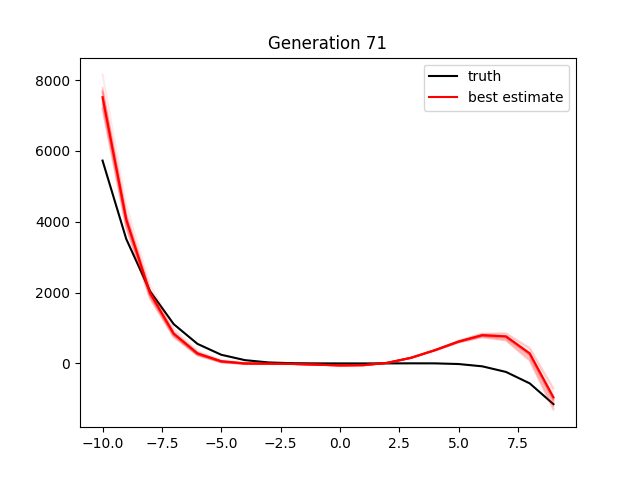

KeyboardInterrupt: 

In [54]:
degree = 5
population = initial_population(100, degree)
data, true_coefficients = make_test_data(50, degree)

fig = plt.figure()
ax = fig.add_subplot(111)
plt.ion()
fig.show()
fig.canvas.draw()

i = 0
while True:
   fitness = [calculate_fitness(data, genome) for genome in population]
   by_fitness = [genome for genome, _ in sorted(zip(population, fitness), key=lambda i: i[1])]
   xs = range(-10,10)
   ys = [polynomial(x/2, true_coefficients) for x in xs]
   ax.clear()
   ax.set_title(f"Generation {i}")
   ax.plot(xs, ys, color=(0.0, 0.0, 0.0, 1.0), label="truth")
   elite = by_fitness[-1]
   ys = [polynomial(x/2, elite) for x in xs]
   ax.plot(xs, ys, color=(1, 0.0, 0.0, 1.0), label="best estimate")
   for n in range(20):
       genome = by_fitness[-(n+1)]
       ys = [polynomial(x/2, genome) for x in xs]
       ax.plot(xs, ys, color=(1, 0.0, 0.0, 0.09))
   ax.legend()
   fig.canvas.draw()
   #print(f"Generation {i} Mean Fitness {sum(fitness) / len(fitness)} Max Fitness {max(fitness)}")
   population = next_generation(population, fitness)
   i += 1
